In [14]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import xtrack as xt
import xobjects as xo
import xpart as xp

import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm








# beta_rel = 0.305
beta_rel = 0.106

# gamma = 1.050
gamma = 1.006


I=0.4
L = 1.5 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 0.01 # <E> [eV] = kb*T
T_l =  0.001 # <E> [eV]
B = 0.060 # T for LEIR
Z=1


c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c



length = 182.43280000000 #m
T = length/(c*beta_rel)
ms_per_turn = 1000*T





beta_x=10 
beta_y=4
emittance=10*1e-6

arc=dtk.LinearTransferMatrix(Q_x=5.38518956965, Q_y=5.36921653748,
                            beta_x_0=beta_x, beta_x_1=beta_x,
                            beta_y_0=beta_y,  beta_y_1=beta_y,
                            alpha_x_0=0,   alpha_x_1=0,
                            alpha_y_0=0,   alpha_y_1=0,
                            disp_x_0=0,disp_x_1=0,
                            disp_y_0=0,    disp_y_1=0,
                            beta_s=1*1e40,
                            Q_s=0,
                            chroma_x=0.0, chroma_y=0
                                           
                 )




num_particles=int(1e4)

#x=np.random.normal(0,np.sqrt(5*emittance) ,num_particles),
#px=np.random.normal(0, np.sqrt(emittance/5), num_particles),
#x=np.linspace(1*1e-3, 20*1e-3, num_particles),
#px=np.random.uniform(0, 0, num_particles),

dtk_particle = dtk.TestParticles(
        
        mass0=mass0,
        p0c=p0c,
        x=np.random.normal(0,np.sqrt(beta_x*emittance) ,num_particles),
        px=np.random.normal(0, np.sqrt(emittance/beta_x), num_particles),
        y=0,
        py=0,
        delta=0,
        zeta=0)

dtk_particle_copy_old=dtk_particle.copy()






In [15]:
xp_cooler=1e-3

B_ratio=1e-3
#RMS = σ * sqrt(2)

dtk_cooler = dtk.elements.ElectronCooler(I=I,L=L,r_beam=r_beam,
                                         T_perp=T_perp,T_l=T_l,
                                         B=B,Z=Z,B_ratio=B_ratio,
                                         Neutralisation_space_charge=0,
                                         xp_cooler=0)

coolers = []
num_coolers=int(1e3)

for i in range(num_coolers):
    #angle=np.random.normal(0,B_ratio,1)
    angle=np.random.uniform(-B_ratio,B_ratio,1)
    #print('angle:',angle)
    cooler = dtk.elements.ElectronCooler(I=I, L=L/num_coolers, r_beam=r_beam,
                                         T_perp=T_perp, T_l=T_l,
                                         B=B, Z=Z, B_ratio=0,
                                         Neutralisation_space_charge=0,
                                         xp_cooler=angle)
    coolers.append(cooler)



In [16]:
num_turns=int(1)


x=[]
px=[]
action = []
force = []
force_old = []


for i in tqdm(range(num_turns)):
    x.append(dtk_particle.x)
    px.append(dtk_particle.px)
    
    action_temp = 0.5*(dtk_particle.x**2/beta_x + beta_x*dtk_particle.px**2) #Joule sec
    action.append(action_temp)
    
    #arc.track(dtk_particle)
    force_temp=[]        

    force_old.append(dtk_cooler.force(dtk_particle))

    for dtk_cooler in coolers:
        force_temp.append(dtk_cooler.force(dtk_particle))
        # dtk_cooler.track(dtk_particle)
    force.append(sum(force_temp)/num_coolers)


x = np.array(x)
px = np.array(px)
action = np.array(action)
force = np.array(force)
force_old = np.array(force_old)

100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


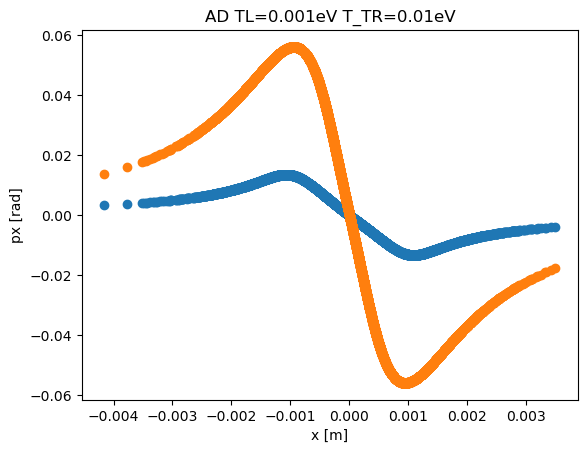

In [20]:
#plot force magnitude in phase space
plt.figure()
plt.scatter(px,force)#,vmin=-0.05, vmax=0.05
plt.scatter(px,force_old)#,vmin=-0.05, vmax=0.05
plt.xlabel('x [m]')
plt.ylabel('px [rad]')
plt.title(f'AD TL={T_l}eV T_TR={T_perp}eV')
plt.show()



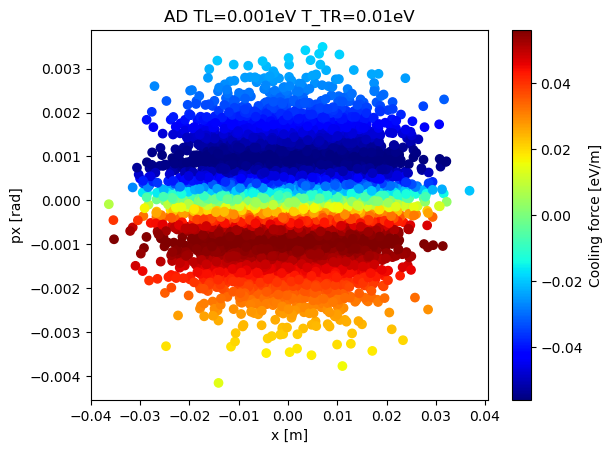

In [18]:
#plot force magnitude in phase space
plt.figure()
plt.scatter(x,px,c=force_old,cmap='jet')#, vmin=-0.05, vmax=0.05
plt.xlabel('x [m]')
plt.ylabel('px [rad]')
plt.title(f'AD TL={T_l}eV T_TR={T_perp}eV')
plt.colorbar().set_label("Cooling force [eV/m]")
plt.show()

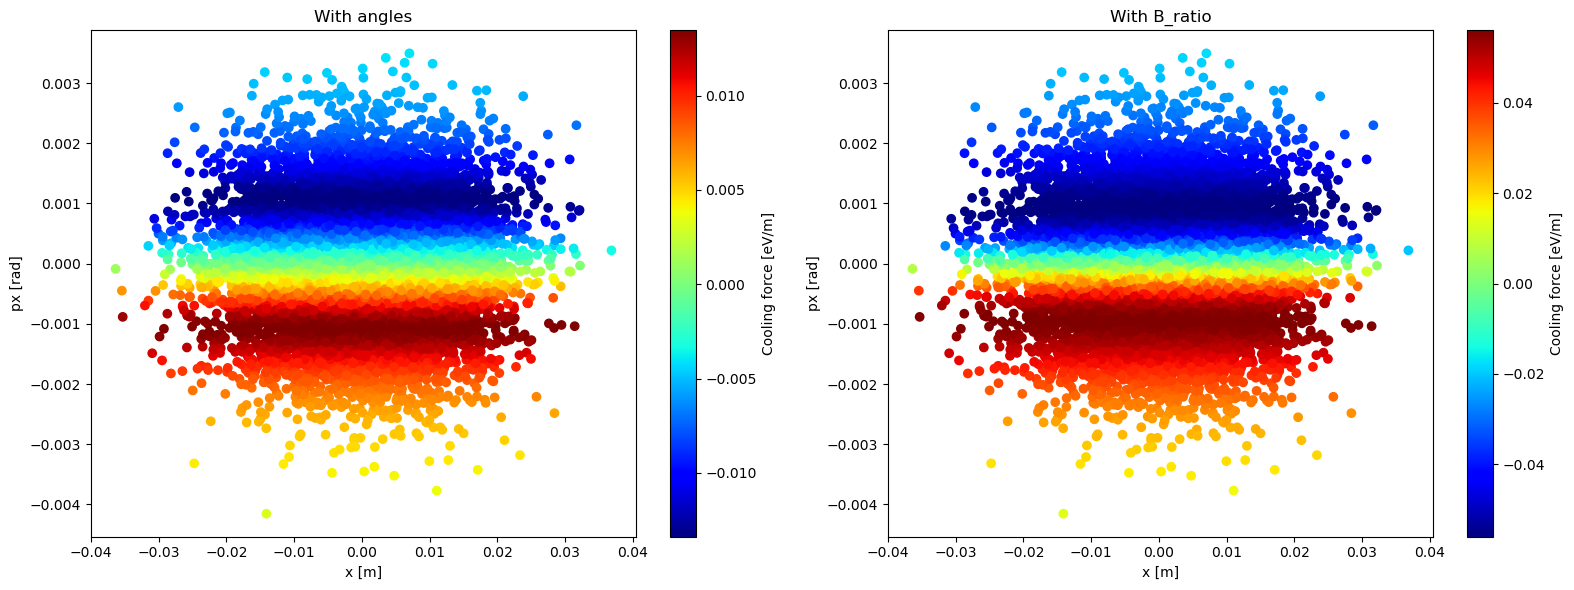

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

# Plot the first heatmap
im1 = axes[0].scatter(x,px,c=force, cmap='jet')
axes[0].set_xlabel('x [m]')
axes[0].set_ylabel('px [rad]')
axes[0].set_title('With angles')
fig.colorbar(im1, ax=axes[0], label='Cooling force [eV/m]')

# Plot the second heatmap
im2 = axes[1].scatter(x,px,c=force_old, cmap='jet')
axes[1].set_xlabel('x [m]')
axes[1].set_ylabel('px [rad]')
axes[1].set_title('With B_ratio')
fig.colorbar(im2, ax=axes[1], label='Cooling force [eV/m]')

plt.tight_layout()
plt.show()

